All the functions we will use are in the file FeatureExtraction.py, which we import here.

In [1]:
run FeatureExtraction.py

We also import a library for displaying images, and another for manifold learning.

In [2]:
from IPython.display import Image, display


import sklearn.cluster as cl
from sklearn.manifold import Isomap

In [3]:
import warnings
warnings.filterwarnings("ignore")

We can write a file for each user:

In [13]:
users = 3 #Sample size
sessions_for_each = 3
directory = 'NewData'

make_directory(directory)

listOfFiles = os.listdir(directory)
listOfFiles = list(filter(lambda x: len(x) == 10 and x[-4:] == '.csv', listOfFiles))
already_written_users = list(map(lambda x: x[0:6], listOfFiles))

user_sample = list(filter(lambda x: not (x in already_written_users), get_user_ids()))
                   #random.sample(get_user_ids(), users)
for user_id in user_sample:
    print(user_id)
    frames = []
    for session in get_user_session_ids(user_id):#random.sample(get_user_session_ids(user_id), sessions_for_each):
        print(session)
        try:
            frames.append(get_feature_vector(user_id, session))
        except:
            print("Error in session " + session)
            continue
    features = pd.concat(frames, ignore_index = True)
    features.to_csv(directory + '/' + user_id + '.csv', header = True, index = False)


We then collect all of the different user's data into a single file:

In [14]:
listOfFiles = os.listdir(directory)
listOfFiles = list(filter(lambda x: len(x) == 10 and x[-4:] == '.csv', listOfFiles))
user_sample = list(map(lambda x: x[0:6], listOfFiles))


file_name = 'DataUpTo248252.csv'

user_data = [pd.read_csv(directory + '/' + user_id + '.csv', header=0, index_col=False) for user_id in user_sample]
aggregate_data = pd.concat(user_data, ignore_index = True)
aggregate_data['TaskName'] = aggregate_data['SessionID'].map(lambda x: dictio[x])
aggregate_data.to_csv(directory + '/' + file_name, header = True, index = False)

We will use this code to do manifold learning on a set of data:

In [4]:
# Let's retrieve the file from the last session
directory = 'NewData'
file_name = 'DataUpTo248252.csv'
data = pd.read_csv(directory + '/' + file_name, header=0, index_col=False)


print("Data read")    

count_matrix = data.UserID.value_counts()
users = count_matrix.index
counts = [count_matrix[u] for u in users]
bad_users = []
for i in range(len(counts)):
    if counts[i] < 100:
        bad_users.append(users[i])   
for b in bad_users:
    data = data[data.UserID != b]

# Natural log some of them columns
for file_name in file_names:
    for y in y_columns[file_name]:
        for suffix in ['_restoration_time', '_normalized_duration', '_normalized_duration_max']:
            data[y + suffix] = log_column(data, y + suffix)

data = data.replace([np.inf, -np.inf], np.nan).dropna()

print("Data processed")

# We're going to try looking at isolating just ONE of a specific feature:
feature = 'UserID'
random_value = random.choice(data[feature].value_counts().index)
data = data[data[feature] == random_value]


numeric_data = data[get_numerical_feature_names()]

numeric_data_training_sample = numeric_data #numeric_data.sample(n = numeric_data.shape[0] // 10, axis = 0)
print("Data sampled")

isomap = Isomap(n_neighbors=5, n_components=3)
isomap.fit(numeric_data_training_sample)
print("Fit created")

data_testing_sample = data #data.sample(n = data.shape[0] // 10, axis = 0)
numeric_data_testing_sample = data_testing_sample[get_numerical_feature_names()]

manifold_3Da = isomap.transform(numeric_data_testing_sample)
print("Data transformed")
manifold_3D = pd.DataFrame(manifold_3Da, columns=['Comp1', 'Comp2', 'Comp3'])
manifold_3D['TapType'] = pd.factorize(data_testing_sample['TapType'])[0]
manifold_3D['TaskName'] = pd.factorize(data_testing_sample['TaskName'])[0]
manifold_3D['UserID'] = pd.factorize(data_testing_sample['UserID'])[0]

Data read
Data processed
Data sampled
Fit created
Data transformed


Now we plot:

In [5]:
def plot_manifold(data: DataFrame, color = None):
    """
    Assume data has the correct columns
    """
    x, y, z = [data[column_name] for column_name in ['Comp1', 'Comp2', 'Comp3']]
    ax = plt.figure().gca(projection='3d')
    if color != None:
        ax.scatter(x, y, z, c=data[color])
        plt.title('Color determined by ' + color)
    else:
        ax.scatter(x, y, z)
    plt.show()
    plt.close()

In [6]:
def all_possible_sublists(elements, length):
    """
    All possible sublists of elements having the specified length and preserving order.
    This should really use dynamic programming, but it uses recursion instead, so don't
    run it on large lists with large values of length
    """
    if length == 0:
        return [[]]
    sublists = []
    for i in range(len(elements)):
        remaining_elements = elements[i+1:]
        smaller_lists = all_possible_sublists(remaining_elements, length - 1)
        append_to_start = lambda x: [elements[i]] + x
        sublists += list(map(append_to_start, smaller_lists))
    return sublists

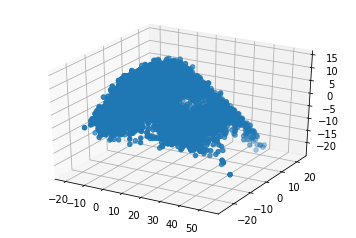

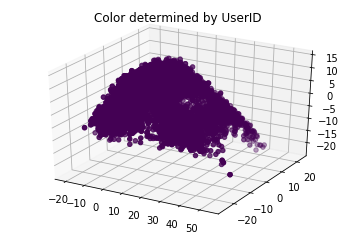

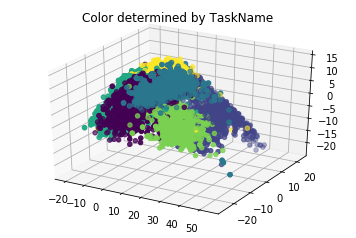

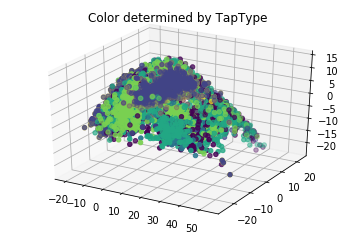

In [7]:
plot_manifold(manifold_3D, color = None)
plot_manifold(manifold_3D, color = 'UserID')
plot_manifold(manifold_3D, color = 'TaskName')
plot_manifold(manifold_3D, color = 'TapType')

Here we select two users at random, and use $k=2$ clustering to try to separate them by user. Could also try for TapType, TaskName.

TaskName Map+Sitting and TaskName Map+Walking


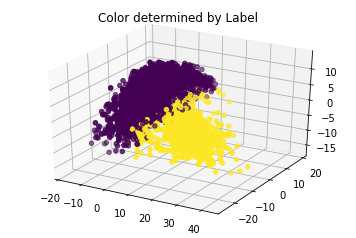

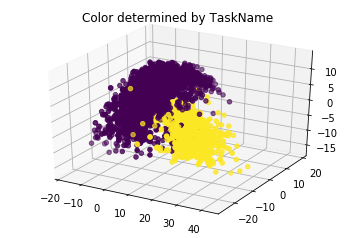

Frequency of most common label: 0.728176201988
Success rate from guessing TaskName by cluster: 0.9363416599516519


In [20]:
feature = 'TaskName'
pair = random.sample(range(len(manifold_3D[feature].value_counts().index)), 2)


user_ids = []
for user_label in pair:
    i = list(manifold_3D[feature].value_counts().index).index(user_label)
    user_ids.append(data[feature].value_counts().index[i])
print(feature,user_ids[0],'and',feature,user_ids[1])

m = manifold_3D[(manifold_3D[feature] == pair[0]) | (manifold_3D[feature] == pair[1])]
kmeans = cl.KMeans(n_clusters=2).fit(m[['Comp1', 'Comp2', 'Comp3']])
m['Label'] = kmeans.labels_ + 1
m[feature] = pd.factorize(m[feature])[0] + 1
plot_manifold(m, color = 'Label')
plot_manifold(m, color = feature)
m['Mix'] = 10 * m['Label'] + m[feature]

max_sum = 0
for a in [[11,22],[12,21]]: #[[11, 22, 33],[11, 23, 32],[12, 21, 33],[12, 23, 31],[13, 21, 32],[13, 22, 31]]:
    sum = len(m[(m.Mix == a[0]) | (m.Mix == a[1])])
    if sum > max_sum:
        max_sum = sum
    
accuracy = max_sum / len(m)
print("Frequency of most common label:", max(m[feature].value_counts()[1], m[feature].value_counts()[2]) / len(m))
print("Success rate from guessing",feature,"by cluster:", accuracy)

Here we do the above for all possible pairs of 2 users:

TaskName Map+Walking and TaskName Reading+Sitting
0.702513604561 0.9681264576315107
TaskName Map+Walking and TaskName Writing+Sitting
0.720082601962 0.7412493546721735
TaskName Map+Walking and TaskName Writing+Walking
0.72065945389 0.7824832560535806
TaskName Map+Walking and TaskName Map+Sitting
0.728176201988 0.9363416599516519
TaskName Map+Walking and TaskName Reading+Walking
0.782169648009 0.5435660703981535
TaskName Reading+Sitting and TaskName Writing+Sitting
0.858655503571 0.9651563654272347
TaskName Reading+Sitting and TaskName Writing+Walking
0.859002702039 0.9893146647015475
TaskName Reading+Sitting and TaskName Map+Sitting
0.531481481481 0.799537037037037
TaskName Reading+Sitting and TaskName Reading+Walking
0.603258013663 0.9432475039411455
TaskName Writing+Sitting and TaskName Writing+Walking
0.500715922108 0.9085767468499427
TaskName Writing+Sitting and TaskName Map+Sitting
0.873278236915 0.986351114450288
TaskName Writing+Sitting and TaskName Reading+Walking
0.90231595290

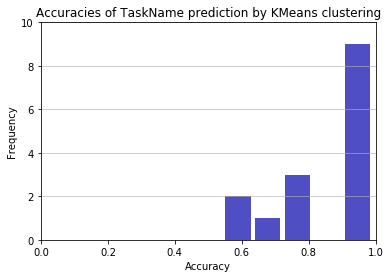

In [21]:
feature = 'TaskName'
accuracies = []
for pair in all_possible_sublists(range(len(manifold_3D[feature].value_counts().index)), 2):
    
    user_ids = []
    for user_label in pair:
        i = list(manifold_3D[feature].value_counts().index).index(user_label)
        user_ids.append(data[feature].value_counts().index[i])
    print(feature,user_ids[0],'and',feature,user_ids[1])
    
    values = []
    for user_label in pair:
        i = list(manifold_3D[feature].value_counts().index).index(user_label)
        values.append(data[feature].value_counts().index[i])
        
    m = manifold_3D[(manifold_3D[feature] == pair[0]) | (manifold_3D[feature] == pair[1])]
    kmeans = cl.KMeans(n_clusters=2).fit(m[['Comp1', 'Comp2', 'Comp3']])
    m['Label'] = kmeans.labels_ + 1
    m[feature] = pd.factorize(m[feature])[0] + 1
    m['Mix'] = 10 * m['Label'] + m[feature]

    max_sum = 0
    for a in [[11,22],[12,21]]: #[[11, 22, 33],[11, 23, 32],[12, 21, 33],[12, 23, 31],[13, 21, 32],[13, 22, 31]]:
        sum = len(m[(m.Mix == a[0]) | (m.Mix == a[1])])
        if sum > max_sum:
            max_sum = sum
    
    accuracies.append(max_sum / len(m))
    print(max(m[feature].value_counts()[1], m[feature].value_counts()[2]) / len(m), max_sum / len(m))
    
m = mean(accuracies)
s = sd(accuracies)
print(m)
print(s)
n, bins, patches = plt.hist(x=accuracies, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracies of ' + feature + ' prediction by KMeans clustering')
maxfreq = n.max()
plt.xlim(xmin=0, xmax=1)
plt.ylim(ymax=maxfreq + 1)
plt.show()

Sitting
Activity Map and Activity Reading


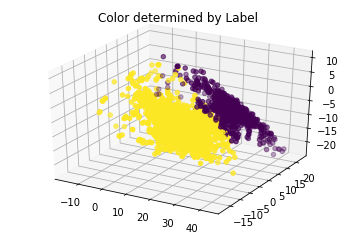

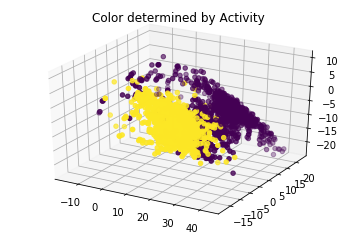

Frequency of most common label: 0.531481481481
Success rate from guessing Activity by cluster: 0.799537037037037
Sitting
Activity Map and Activity Writing


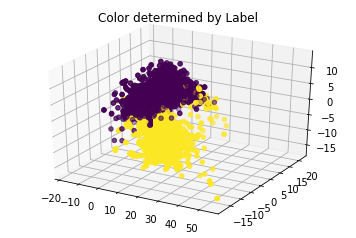

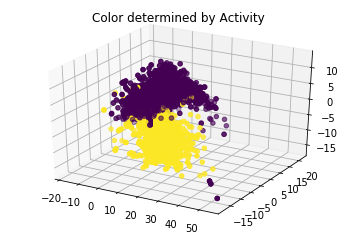

Frequency of most common label: 0.873278236915
Success rate from guessing Activity by cluster: 0.986351114450288
Sitting
Activity Reading and Activity Writing


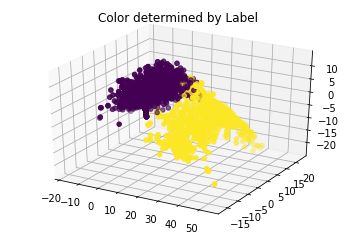

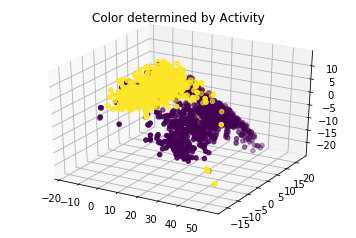

Frequency of most common label: 0.858655503571
Success rate from guessing Activity by cluster: 0.9651563654272347
Walking
Activity Map and Activity Reading


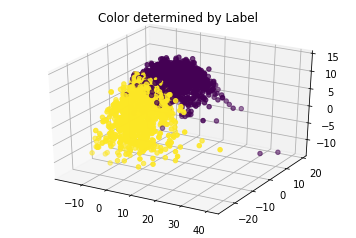

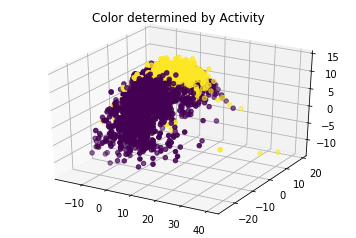

Frequency of most common label: 0.782169648009
Success rate from guessing Activity by cluster: 0.5435660703981535
Walking
Activity Map and Activity Writing


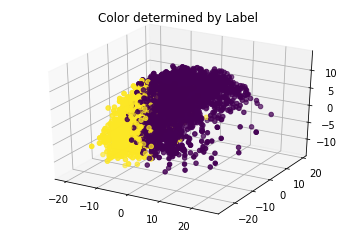

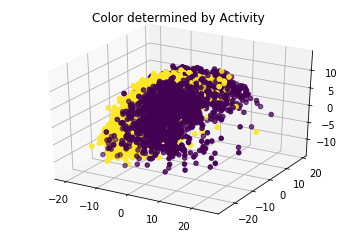

Frequency of most common label: 0.72065945389
Success rate from guessing Activity by cluster: 0.7845440494590418
Walking
Activity Reading and Activity Writing


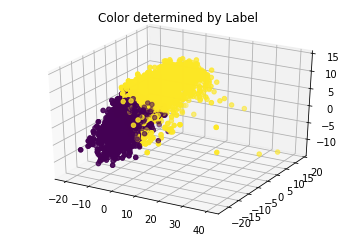

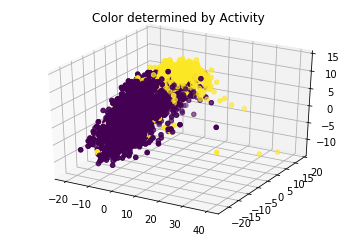

Frequency of most common label: 0.9025680733
Success rate from guessing Activity by cluster: 0.6336301458252678


In [59]:
gesture_dict = {'Map+Sitting': 0,
                'Map+Walking': 1,
                'Reading+Sitting': 0,
                'Reading+Walking': 1,
                'Writing+Sitting': 0,
                'Writing+Walking': 1}

gesture_labels = ['Sitting', 'Walking']

relabel = pd.factorize(data_testing_sample['TaskName'])[1]

manifold_3D['GestureScenario'] = manifold_3D['TaskName'].map(lambda x : gesture_dict[relabel[x]])

activity_dict = {'Map+Sitting': 0,
                'Map+Walking': 0,
                'Reading+Sitting': 1,
                'Reading+Walking': 1,
                'Writing+Sitting': 2,
                'Writing+Walking': 2}

activity_labels = ['Map', 'Reading', 'Writing']

manifold_3D['Activity'] = manifold_3D['TaskName'].map(lambda x : activity_dict[relabel[x]])


feature = 'Activity'

for i in range(len(gesture_labels)):
    
    mani = manifold_3D[manifold_3D['GestureScenario'] == i]
    
    for pair in all_possible_sublists(range(len(mani[feature].value_counts().index)), 2):
        print(gesture_labels[i])
        print(feature,activity_labels[pair[0]],'and',feature,activity_labels[pair[1]])

        m = mani[(mani[feature] == pair[0]) | (mani[feature] == pair[1])] #| (m[feature] == pair[2])]
        kmeans = cl.KMeans(n_clusters=2).fit(m[['Comp1', 'Comp2', 'Comp3']])
        m['Label'] = kmeans.labels_ + 1
        m[feature] = pd.factorize(m[feature])[0] + 1
        plot_manifold(m, color = 'Label')
        plot_manifold(m, color = feature)
        m['Mix'] = 10 * m['Label'] + m[feature]

        max_sum = 0
        for a in [[11,22],[12,21]]: #[[11, 22, 33],[11, 23, 32],[12, 21, 33],[12, 23, 31],[13, 21, 32],[13, 22, 31]]:
            sum = len(m[(m.Mix == a[0]) | (m.Mix == a[1])]) # | (m.Mix == a[2])])
            if sum > max_sum:
                max_sum = sum

        accuracy = max_sum / len(m)
        print("Frequency of most common label:", \
              max(m[feature].value_counts()[1], m[feature].value_counts()[2]) / len(m))
        print("Success rate from guessing",feature,"by cluster:", accuracy)

In [17]:
# Save the manifold to a file in case we need it later:

factor = pd.factorize(data_testing_sample['TapType'])[1]
manifold_3D['TapType_name'] = manifold_3D['TapType'].map(lambda x: factor[x])
factor = pd.factorize(data_testing_sample['TaskName'])[1]
manifold_3D['TaskName_name'] = manifold_3D['TaskName'].map(lambda x: factor[x])
factor = pd.factorize(data_testing_sample['UserID'])[1]
manifold_3D['UserID_name'] = manifold_3D['UserID'].map(lambda x: factor[x])
                                          
manifold_3D.to_csv('NewData/ManifoldFit.csv', header = True, index = False)

Out of curiosity, the same thing in 2D:

In [35]:
numeric_data = data[get_numerical_feature_names()]

numeric_data_training_sample = numeric_data.sample(n = numeric_data.shape[0] // 100, axis = 0)
print("Data sampled")

isomap = Isomap(n_neighbors=5, n_components=2)
isomap.fit(numeric_data_training_sample)
print("Fit created")

data_testing_sample = data.sample(n = data.shape[0] // 100, axis = 0)
numeric_data_testing_sample = data_testing_sample[get_numerical_feature_names()]

manifold_2Da = isomap.transform(numeric_data_testing_sample)
print("Data transformed")
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Comp1', 'Comp2'])
manifold_2D['TapType'] = pd.factorize(data_testing_sample['TapType'])[0]
manifold_2D['TaskName'] = pd.factorize(data_testing_sample['TaskName'])[0]
manifold_2D['UserID'] = pd.factorize(data_testing_sample['UserID'])[0]

Data sampled
Fit created
Data transformed


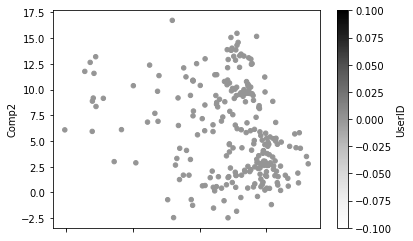

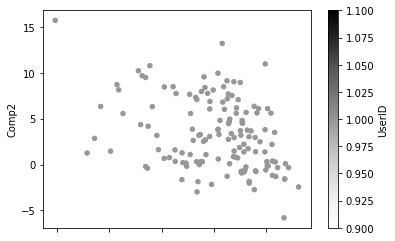

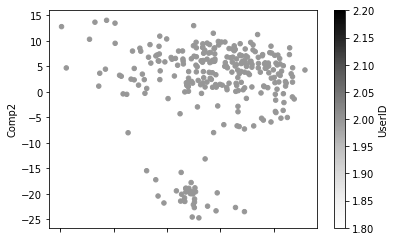

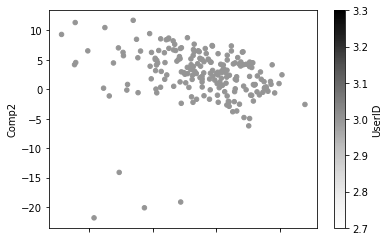

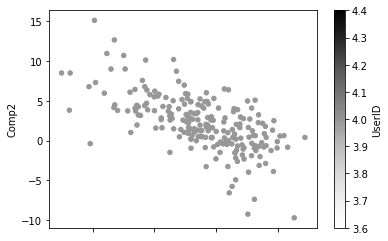

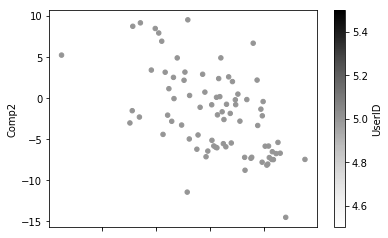

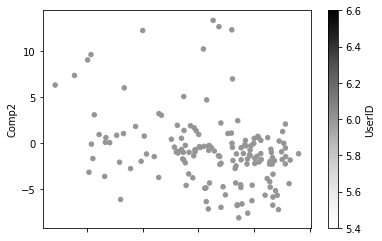

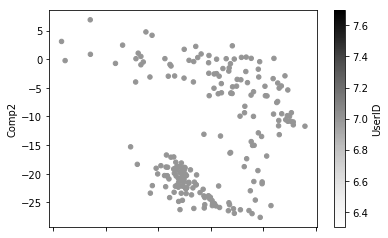

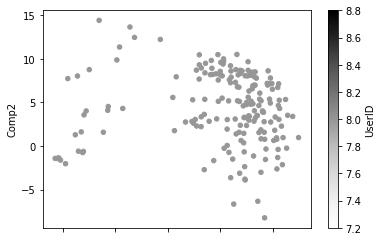

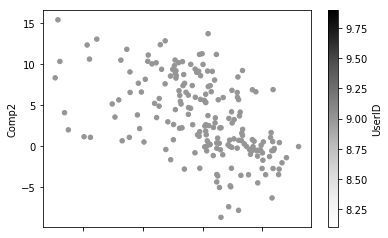

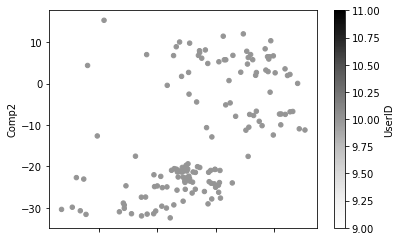

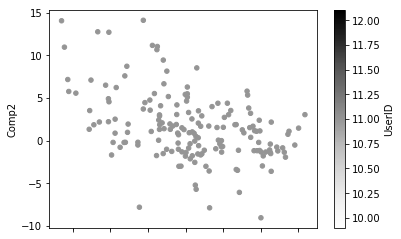

In [49]:
for u in range(len(manifold_2D.UserID.value_counts())):
    manifold_2D[manifold_2D.UserID == u].plot(x = 'Comp1', y = 'Comp2', kind = 'scatter', c = 'UserID')
    plt.show()
    plt.close()

In [47]:
manifold_3D[feature].value_counts()

2    13968
0     3723
1     1903
Name: Activity, dtype: int64

In [53]:
manifold_3D.TaskName.value_counts()

3    6994
2    6974
0    2711
1    1148
4    1012
5     755
Name: TaskName, dtype: int64